In [1]:
%pylab inline
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn import grid_search
from sklearn import cross_validation
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
sns.set_context('talk')
sns.set_style('whitegrid') 

rcParams['figure.figsize'] = (8.0, 6.0)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plotROCCurve(y_test, prediction_prob):
    fpr, tpr, thresholds = roc_curve(y_test, prediction_prob[:,1])
    roc_auc = auc(fpr, tpr)
    plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plot([0, 1], [0, 1], 'k--')
    xlabel('False Positive Rate')
    ylabel('True Positive Rate')
    plt.legend(bbox_to_anchor=(0.9, 0.2),
               bbox_transform=plt.gcf().transFigure)
    savefig('logistic_regression_aucroc.png', bbox_inches='tight', dpi=150)

In [3]:
all_X_df = pd.read_pickle('new_X_df.save')
outcomes_df = pd.read_pickle('new_outcomes_df.save')

In [4]:
np.array(all_X_df.columns)

array(['Goal', 'Campaign_days', 'Title_n_words', 'Blurb_n_words',
       'Has_video', 'N_rewards', 'Min_reward', 'Median_reward',
       'Max_reward', 'Reward_ship_days', 'N_links', 'N_figs',
       'Body_n_words', 'N_creator_backed', 'N_creator_created', 'art',
       'comics', 'crafts', 'dance', 'design', 'fashion', 'film', 'food',
       'games', 'journalism', 'music', 'photography', 'publishing',
       'technology', 'theater', 'Ships_intn', 'Mon', 'Tue', 'Wed', 'Thu',
       'Fri', 'Sat', 'Sun'], dtype=object)

In [5]:
cols_small = ['Goal', 'Campaign_days', 'Title_n_words', 'Blurb_n_words',
       'Has_video', 'N_rewards', 'Min_reward', 'Median_reward',
       'Max_reward', 'Reward_ship_days', 'N_links', 'N_figs',
       'Body_n_words', 'N_creator_backed', 'N_creator_created',
              'Ships_intn', 'Mon', 'Tue', 'Wed', 'Thu',
       'Fri', 'Sat', 'Sun']

In [6]:
X_df = all_X_df.ix[:,cols_small]

In [7]:
X_train, X_test, y_train, y_test = \
    cross_validation.train_test_split(X_df, outcomes_df['Outcome'].values, \
                                      test_size=0.25, random_state=2) # was 0

In [8]:
C = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4]
param_grid = {'penalty':['l2'], 'C': C}
#param_grid = {'penalty':['l1', 'l2'], 'C': C}

In [9]:
logistic_regressions = grid_search.GridSearchCV(LogisticRegression(class_weight='auto'), cv=5, 
                                                param_grid=param_grid, scoring='roc_auc', 
                                                n_jobs=-1, verbose=1)

In [10]:
logistic_regressions.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   11.9s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid={'penalty': ['l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 1, 100.0, 1000.0, 10000.0]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='roc_auc', verbose=1)

In [11]:
for score in logistic_regressions.grid_scores_:
    print score

mean: 0.76073, std: 0.00350, params: {'penalty': 'l2', 'C': 0.0001}
mean: 0.76105, std: 0.00320, params: {'penalty': 'l2', 'C': 0.001}
mean: 0.76102, std: 0.00360, params: {'penalty': 'l2', 'C': 0.01}
mean: 0.76147, std: 0.00324, params: {'penalty': 'l2', 'C': 0.1}
mean: 0.76131, std: 0.00310, params: {'penalty': 'l2', 'C': 1}
mean: 0.76167, std: 0.00325, params: {'penalty': 'l2', 'C': 100.0}
mean: 0.76146, std: 0.00321, params: {'penalty': 'l2', 'C': 1000.0}
mean: 0.76066, std: 0.00299, params: {'penalty': 'l2', 'C': 10000.0}


In [12]:
logistic_regressions.best_params_

{'C': 100.0, 'penalty': 'l2'}

In [13]:
logistic_regressions.best_score_

0.76166875198258066

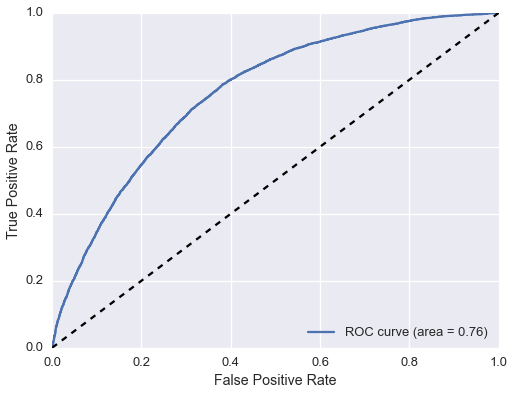

In [14]:
plotROCCurve(y_test, logistic_regressions.predict_proba(X_test))

In [15]:
y_1 = logistic_regressions.predict(X_test)
y_1_proba = logistic_regressions.predict_proba(X_test)

In [16]:
metrics.accuracy_score(y_test,y_1, normalize=True)

0.69748949616306122

In [17]:
print metrics.classification_report(y_test, y_1)

             precision    recall  f1-score   support

          0       0.77      0.70      0.73     16892
          1       0.62      0.70      0.66     11907

avg / total       0.71      0.70      0.70     28799



In [18]:
from plot_suggestions import *
%load_ext autoreload
%autoreload 2

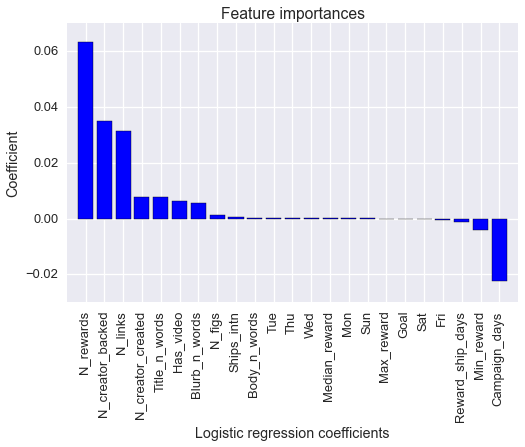

In [19]:
coefs = logistic_regressions.best_estimator_.coef_[0]
plot_coefficients(coefs,X_df.columns,len(coefs))